In [27]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamPredictor

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
checkpoint = r"/home/a/sam_vit_h_4b8939.pth"
model_type = "vit_h"
sam = sam_model_registry[model_type](checkpoint=checkpoint)
sam.to(device='cuda')

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0): Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELU()
        )
      )
      (1): Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        

In [22]:
from tools.dataset_util import Dataset
idx = 10
dataset = Dataset("train", r"/mnt/e/DataSet/kitti")


In [5]:

from segment_anything.utils.transforms import ResizeLongestSide

resize_transform = ResizeLongestSide(sam.image_encoder.img_size)

def prepare_image(image, transform, device):
    image = transform.apply_image(image)
    image = torch.as_tensor(image, device=device.device) 
    return image.permute(2, 0, 1).contiguous()

def get_image_with_boxes(dataset, idx, device):
    image = dataset.get_image(idx)
    h,w,_ = image.shape
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    bbox2d, cls, label = dataset.get_bbox2d(idx, chosen_cls=["Car"])
    boxes, label_new, sizes = [], [], []
    for box, c, l in zip(bbox2d, cls, label):
        if l.occlusion != 0:
            continue
        size = (box[2] - box[0]) * (box[3] - box[1])
        expand = 5
        box[0] = max(box[0] - expand, 0)
        box[1] = max(box[1] - expand, 0)
        box[2] = min(box[2] + expand, w)
        box[3] = min(box[3] + expand, h)
        if box[0] == 0 or box[1] == 0 or box[2] == w or box[3] == h:
            continue
        sizes.append(size)
        boxes.append(box)
        label_new.append(l)
    boxes = torch.tensor(boxes).to(device.device)
    return image, boxes, label_new, sizes
        


In [10]:
image1, image1_boxes, _ = get_image_with_boxes(dataset, idx, sam)
image2, image2_boxes, _ = get_image_with_boxes(dataset, idx + 1, sam)


batched_input = [
     {
         'image': prepare_image(image1, resize_transform, sam),
         'boxes': resize_transform.apply_boxes_torch(image1_boxes, image1.shape[:2]),
         'original_size': image1.shape[:2]
     },
    # {
    #      'image': prepare_image(image2, resize_transform, sam),
    #      'boxes': resize_transform.apply_boxes_torch(image2_boxes, image2.shape[:2]),
    #      'original_size': image2.shape[:2]
    #  },
]

/tmp/ipykernel_25809/2005584846.py:27: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  boxes = torch.tensor(boxes).to(device.device)


In [11]:
print(batched_input[0]['boxes'])

tensor([[287.7423, 149.1440, 457.5845, 246.3760],
        [671.9485, 142.5520, 768.4122, 211.7680],
        [456.7601, 143.3760, 527.6650, 194.4640]], device='cuda:0')


In [12]:
batched_output = sam(batched_input, multimask_output=False)

In [59]:
np.sum(batched_output[0]['masks'][0][0].cpu().numpy())

12722

In [6]:

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2)) 

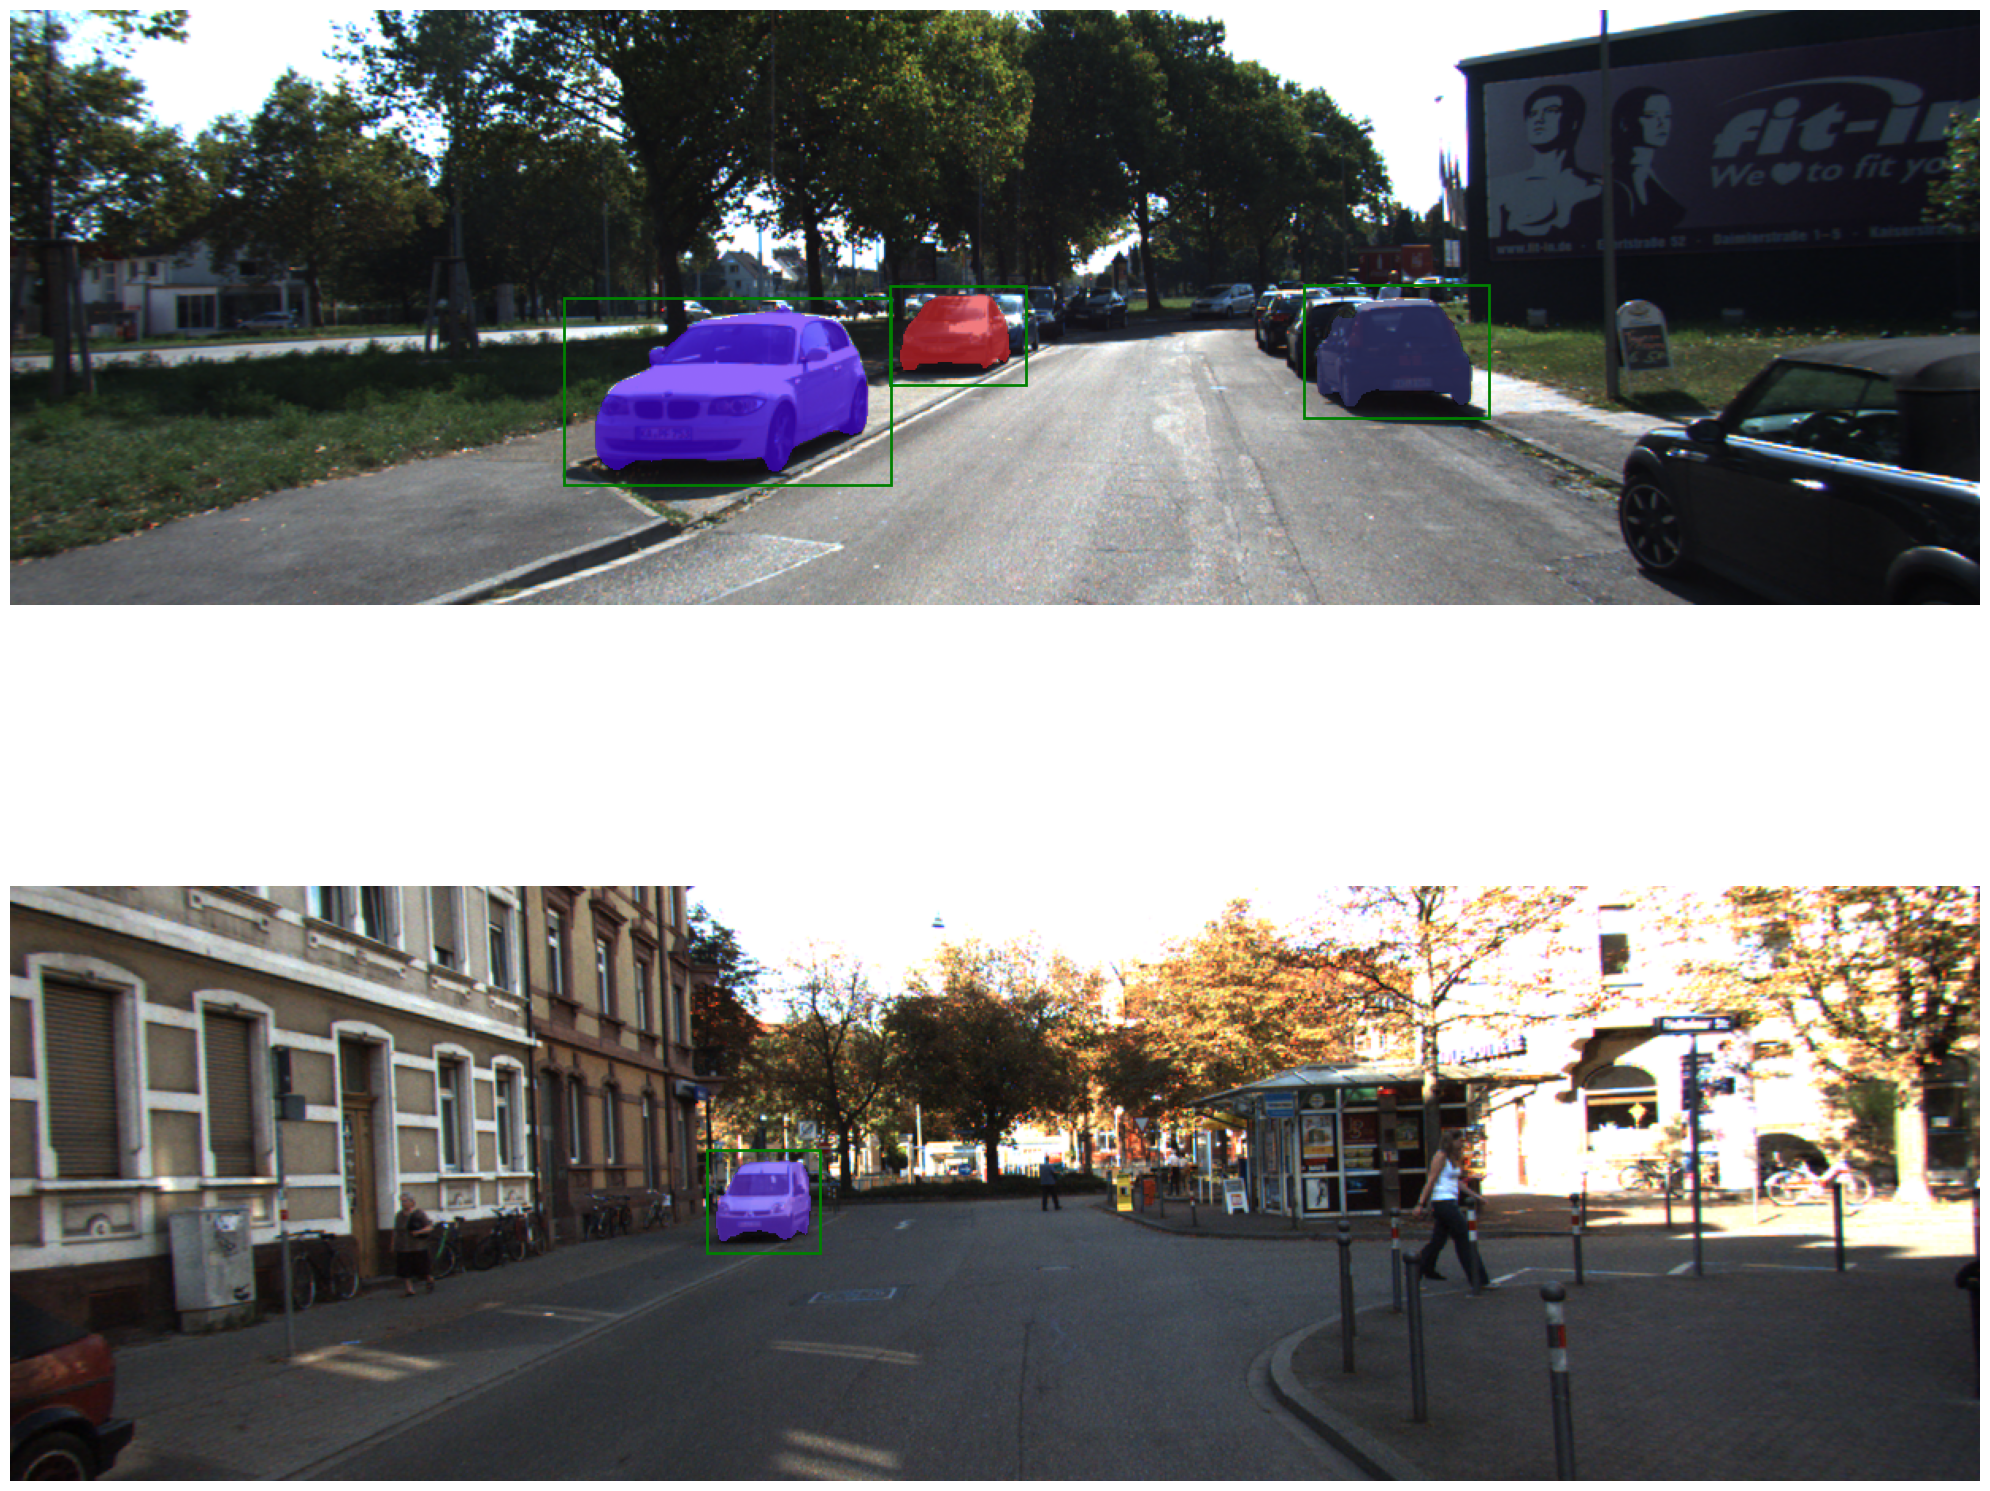

In [64]:
fig, ax = plt.subplots(2, 1, figsize=(20, 20))

ax[0].imshow(image1)
for mask in batched_output[0]['masks']:
    show_mask(mask.cpu().numpy(), ax[0], random_color=True)
for box in image1_boxes:
    show_box(box.cpu().numpy(), ax[0])
ax[0].axis('off')

ax[1].imshow(image2)
for mask in batched_output[1]['masks']:
    show_mask(mask.cpu().numpy(), ax[1], random_color=True)
for box in image2_boxes:
    show_box(box.cpu().numpy(), ax[1])
ax[1].axis('off')

plt.tight_layout()
plt.show()

In [32]:
mask = batched_output[0]['masks'].cpu().numpy()[0]
print(mask.shape)
mask = mask.reshape(375, 1242)
c,_ = cv2.findContours(mask.astype(np.uint8) * 255, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cv2.boundingRect(c[0])


(1, 375, 1242)


(369, 186, 172, 105)

In [71]:
def mask_filter(mask, score, size, threshold = 0.3):
    c, h, w, _ = mask.shape
    assert score.shape[0] == c and isinstance(score, np.ndarray)
    for i in range(c):
        mask_size = np.sum(mask[i])
        if mask_size < size * threshold:
            score[i] = 0    # 舍弃该 mask
    return np.argmax(score)
        

In [32]:
import os
from tools.sample_util import Sample
from pathlib import Path
idx = 6

root_dir = Path(r"/mnt/e/DataSet/kitti/kitti_img_database")
image_dir = root_dir / "image"
mask_dir = root_dir / "mask"
depth_dir = root_dir / "depth"
fix_dir = root_dir / "fix"

database = dict()
for idx in range(7481):
    name = str(idx).zfill(6)
    image, boxes, labels, sizes = get_image_with_boxes(dataset, idx, sam)
    if not labels:
        continue
    _, depth = dataset.get_image_with_depth(idx)
    calib = dataset.get_calib(idx)
    plane = dataset.get_plane(idx)
    
    batch_input = [
        {
             'image': prepare_image(image, resize_transform, sam),
             'boxes': resize_transform.apply_boxes_torch(boxes, image.shape[:2]),
             'original_size': image.shape[:2]
        }
    ]
    batch_output = sam(batch_input, multimask_output=False)
    masks = batch_output[0]['masks'].cpu().numpy()
    scores = batch_output[0]['iou_predictions'].cpu().numpy()
    
    n, c, h, w = masks.shape
    masks = masks.reshape(n, c, h, w, 1)
    for i, (mask, label, score, size) in enumerate(zip(masks, labels, scores, sizes)):
        if label.pos[-1] > 30:
            continue
        mask = mask[0]
        masked = image * mask
        masked_depth = depth.reshape(h, w, 1) * mask
        mask = mask.astype(np.uint8) * 255
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        #cnt = max(contours, key=cv2.contourArea)    # 最好使用 [0]
        cnt = contours[0]
        x, y, w_, h_ = cv2.boundingRect(cnt)
        masked = masked[y:y+h_, x:x+w_]
        if w_ * h_ < 500:
            cv2.imwrite(str(fix_dir / f"{name}_{i}.png"), masked)
            continue
        mask = mask[y:y+h_, x:x+w_]
        masked_depth = (masked_depth[y:y+h_, x:x+w_] * 256.0).astype(np.uint16)
        cv2.imwrite(str(image_dir / f"{name}_{i}.png"), masked)
        cv2.imwrite(str(mask_dir / f"{name}_{i}.png"), mask)
        cv2.imwrite(str(depth_dir/ f"{name}_{i}.png"), masked_depth )
        database[f"{name}_{i}"] = {
            "label": label,
            "bbox2d": [x, y, x+w_, y+h_],
            "name": f"{name}_{i}",
            "calib": calib,
            "plane": plane
        }

import pickle
with open(root_dir / "kitti_car_database.pkl", "wb") as f:
    pickle.dump(database, f)
    

In [37]:
import pickle
with open(root_dir / "kitti_car_database.pkl", "wb") as f:
    pickle.dump(database, f)

In [36]:
all_image = os.listdir(image_dir)
all_image = set([name.split('.')[0] for name in all_image])

all_key = set(database.keys())

print(all_key - all_image)

set()


In [35]:
for name in all_key - all_image:
    del database[name]
    os.remove(mask_dir / (name + ".png"))
    os.remove(depth_dir / (name + ".png"))
    

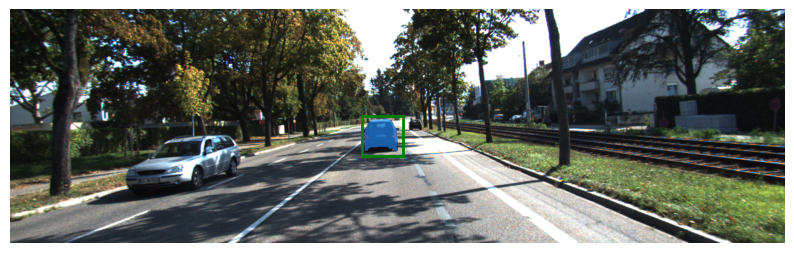

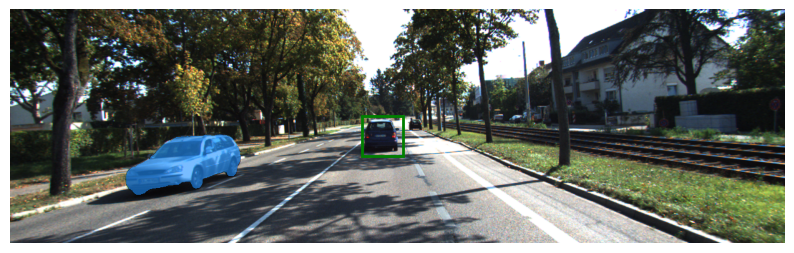

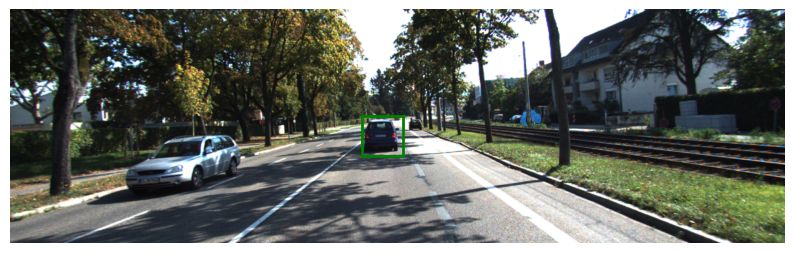

In [11]:
for i, (mask, score) in enumerate(zip(batch_output[0]['masks'], batch_output[0]['iou_predictions'])):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask[0].cpu(), plt.gca())
    show_box(boxes[0].cpu(), plt.gca())
    #show_points(input_point, input_label, plt.gca())
    plt.axis('off')
    plt.show()  

In [97]:
all_file = os.listdir(str(mask_dir))

for file in all_file:
    full_path = mask_dir / file
    mask = cv2.imread(str(full_path))
    mask_size = np.sum(mask.astype(bool))
    if 10 * 10 > mask_size:
        os.remove(full_path)
        os.remove(image_dir / file)
    
    

In [ ]:
21 248 519 691 734 785 1071 1244 1248 1465 1618 1769 1959